In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import traceback

#PATH = Path('../data/mnist_kaggle/')
PATH = Path('../../data/mnist_kaggle/')
IMG_SIZE = 28

In [3]:
[x for x in PATH.iterdir()]

[PosixPath('../../data/mnist_kaggle/sample_submission.csv'),
 PosixPath('../../data/mnist_kaggle/test'),
 PosixPath('../../data/mnist_kaggle/models'),
 PosixPath('../../data/mnist_kaggle/train.csv'),
 PosixPath('../../data/mnist_kaggle/test.csv'),
 PosixPath('../../data/mnist_kaggle/train'),
 PosixPath('../../data/mnist_kaggle/tmp')]

In [4]:
test = pd.read_csv(filepath_or_buffer=PATH/'test.csv')
test.shape

(28000, 784)

In [5]:
all_train = pd.read_csv(filepath_or_buffer=PATH/'train.csv')
all_train.shape

(42000, 785)

In [8]:
val_ids = get_cv_idxs(all_train['label'].size)
train = all_train.drop(all_train.index[val_ids])
valid = all_train.iloc[val_ids]
train.shape, valid.shape

((33600, 785), (8400, 785))

In [9]:
train_y = np.array(train['label'])
train_x = np.repeat(np.array(train.iloc[:,1:]), 3, axis=1)
train_x = train_x.astype(np.float32)

valid_y = np.array(valid['label'])
valid_x = np.repeat(np.array(valid.iloc[:,1:]), 3, axis=1)
valid_x = valid_x.astype(np.float32)

In [10]:
train_x.shape, valid_x.shape

((33600, 2352), (8400, 2352))

In [11]:
train_x = train_x.reshape(train_x.shape[0], 3, 28, 28); train_x.shape

(33600, 3, 28, 28)

In [12]:
valid_x = valid_x.reshape(valid_x.shape[0], 3, 28, 28); valid_x.shape

(8400, 3, 28, 28)

In [13]:
test_x = np.repeat(np.array(test.iloc[:,0:]), 3, axis=1)
test_x = test_x.astype(np.float32)

test_x = test_x.reshape(test_x.shape[0], 3, 28, 28)
test_x.shape

(28000, 3, 28, 28)

In [27]:
arch=resnet34
data = ImageClassifierData.from_arrays(PATH, trn=(train_x, train_y), val=(valid_x, valid_y), test=test_x,
                                       tfms=(None, None))

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 132/132 [00:01<00:00, 66.52it/s]


In [29]:
lrf=learn.lr_find()

 84%|████████▍ | 442/525 [00:06<00:01, 66.18it/s, loss=4.83]


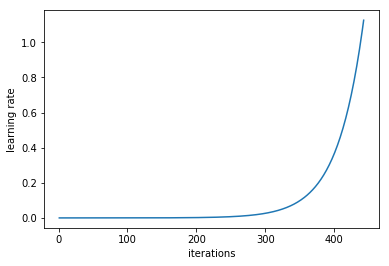

In [30]:
learn.sched.plot_lr()

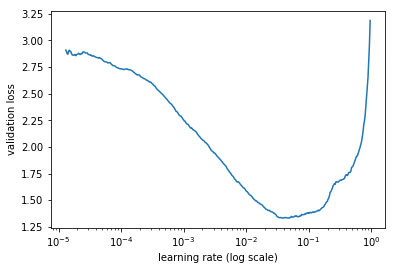

In [31]:
learn.sched.plot()

In [32]:
lr = 0.01

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [34]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.916252   0.740818   0.759167  



[array([0.74082]), 0.7591666666666667]

In [35]:
learn.precompute=False

In [36]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.823368   0.658822   0.788333  
    1      0.791894   0.630822   0.799405                    
    2      0.763884   0.605052   0.804881                    



[array([0.60505]), 0.8048809523809524]

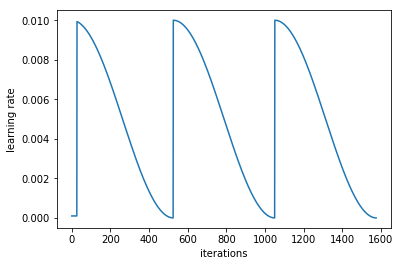

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save('28_lastlayer')

In [39]:
learn.load('28_lastlayer')

In [40]:
learn.unfreeze()

In [41]:
lr=np.array([1e-4,1e-3,1e-2])

In [42]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.463584   0.360234   0.88      
    1      0.290626   0.22912    0.927143                    
    2      0.185817   0.21117    0.93381                     
    3      0.183385   0.186196   0.941548                    
    4      0.120731   0.173027   0.9475                      
    5      0.07156    0.165942   0.95                         
    6      0.057628   0.17058    0.948571                     



[array([0.17058]), 0.9485714285714286]

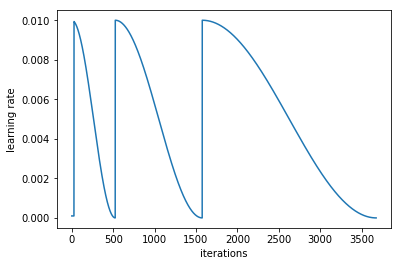

In [43]:
learn.sched.plot_lr()

In [44]:
learn.save('28_all')

In [45]:
learn.load('28_all')

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [47]:
accuracy_np(probs, y)

0.9485714285714286

In [99]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 3, 3]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 1, 1]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 1, 1]),
                           (

In [100]:
data.classes

In [48]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)

In [49]:
probs.shape

(28000, 10)

In [51]:
df = pd.DataFrame(probs)

In [52]:
df['Label'] = df.idxmax(axis=1)

In [57]:
df.index += 1

In [58]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,Label
1,6.559366e-07,0.000001,0.999993,0.000002,3.184060e-08,4.062035e-07,0.000001,5.479134e-07,1.010369e-07,4.840426e-09,2


In [64]:
df.to_csv('subm.gz', columns=['Label'], compression='gzip', index_label='ImageId')

In [65]:
FileLink(f'subm.gz')

/home/paperspace/fastai/fastai_learn/subm.gz